In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
from sklearn.model_selection import GridSearchCV
sys.path.append('../') 

In [3]:
#cpath = '/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap/dataexp/pySuStaIn/dat/'
cpath = "/Users/linlin/Desktop/brain stuff/data/"  
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]   
#lftp = pd.read_csv(cpath+'lftp.csv')
df = pd.read_csv(cpath+'wide_mean_suvr.csv') 
zdf = pd.read_csv(cpath+'full_gmm2z_exclude.csv')
zdata = zdf.loc[:,lobes].values
dat = df.loc[:,lobes].values 
cn_idx = df.index[df['dx'] == 'CN']
eoad_idx = df.index[df['dx'] == 'EOAD'] 


## gmm z-score 


https://scikit-learn.org/stable/modules/mixture.html 

covariances: n_feature = 1

assume k component

(n_components,)                        if 'spherical', dim = k, each component has own single var = own sd

(n_features, n_features)               if 'tied',      dim = 1, all components has same general cov = same sd

(n_components, n_features)             if 'diag',      dim = k, each component has own diagnoal cov = own sd

(n_components, n_features, n_features) if 'full'       dim = k, each component has own general cov = own sd


## best # of GMM components 

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

### wo strat bic

In [8]:
inits = ['random_from_data','kmeans','random']
n_components_range = range(1, 6) 
bestk_df = pd.DataFrame(columns=['ROI', 'K', 'BIC','mean1','weight1','sd1']) 
for roi_idx, roi_data in enumerate(dat.T):  
    bic_scores = [] 
    for n_components in n_components_range:
        gmm_model =  GaussianMixture(n_components=n_components,
                                    n_init=100,
                                    init_params='random_from_data',
                                    max_iter=300,
                                    covariance_type='full', 
                                    tol = 0,
                                    random_state=42)
        gmm_model.fit(roi_data.reshape(-1, 1))  
        means = gmm_model.means_.flatten()
        sds =  np.sqrt(gmm_model.covariances_.flatten())
        weights = gmm_model.weights_.flatten()
        c1_idx = np.argmin(means)  
        bic_score = gmm_model.bic(roi_data.reshape(-1, 1)) 
        # Store the results for each component
        n_results = pd.DataFrame({'ROI': lobes[roi_idx],
                                    'K': n_components,
                                    'BIC': bic_score,
                                    'mean1':[means[c1_idx]],
                                    #'init':init,
                                    'weight1':weights[c1_idx],
                                    'sd1':sds[c1_idx]})
                                    #'n_init':n_i
        bestk_df = pd.concat([bestk_df, n_results], ignore_index=True) 
bestk_df.head(2)


/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 100 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_5592/1849535853.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bestk_df = pd.concat([bestk_df, n_results], ignore_index=True)


KeyboardInterrupt: 

In [14]:
# get best K for each ROI based on lowest mean AIC scores across folds
mean_bic = bestk_df.groupby(['ROI','K']).mean().reset_index()
idx_min = mean_bic.groupby('ROI')['BIC'].idxmin()
bestK = mean_bic.loc[idx_min, ['ROI', 'K','BIC']] 
bestK.sort_values('K')

,ROI,K,BIC
1,L_MTL,2,239.158340
6,L_frontal,2,483.678584
16,L_parietal,2,785.842139
21,L_temporal,2,690.069569
26,R_MTL,2,205.259189
31,R_frontal,2,420.810138
41,R_parietal,2,774.453584
46,R_temporal,2,626.518957
12,L_occipital,3,599.572160
37,R_occipital,3,549.637945


### graphing

### bic

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


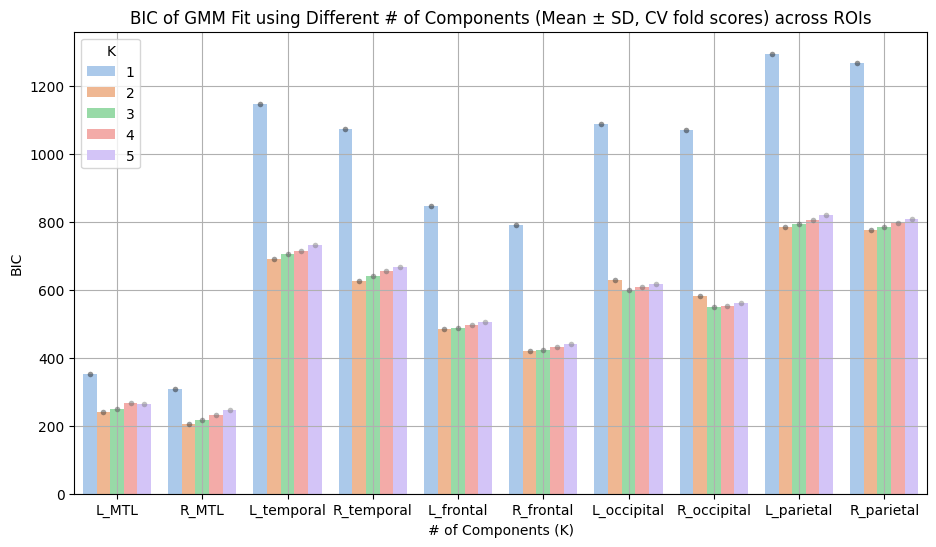

In [15]:
#BIC clustered bar
plt.figure(figsize=(11, 6))
sns.barplot(data=bestk_df, y='BIC', hue='K', x='ROI',   errorbar='sd', errwidth=1, palette=sns.color_palette('pastel')) 
sns.stripplot(data=bestk_df, y='BIC', hue='K', x='ROI', dodge=True, color='gray', alpha=0.5, size=4, legend=False)

plt.xlabel('# of Components (K)')
plt.ylabel('BIC')
plt.title('BIC of GMM Fit using Different # of Components (Mean ± SD, CV fold scores) across ROIs')
plt.legend(title='K')
plt.grid(True)
plt.show() 

### mean

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


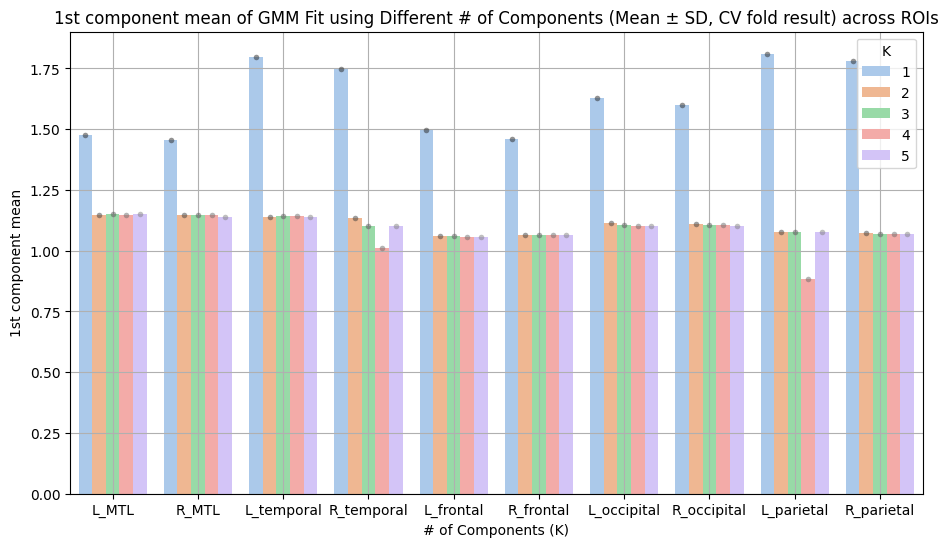

In [16]:
#1/2nd component mean with different components
plt.figure(figsize=(11, 6))
sns.barplot(data=bestk_df, y='mean1', hue='K', x='ROI',   errorbar='sd', errwidth=1, palette=sns.color_palette('pastel')) 
sns.stripplot(data=bestk_df, y='mean1', hue='K', x='ROI', dodge=True, color='gray', alpha=0.5, size=4, legend=False)

plt.xlabel('# of Components (K)')
plt.ylabel('1st component mean')
plt.title('1st component mean of GMM Fit using Different # of Components (Mean ± SD, CV fold result) across ROIs')
plt.legend(title='K')
plt.grid(True)
plt.show() 

### sd

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


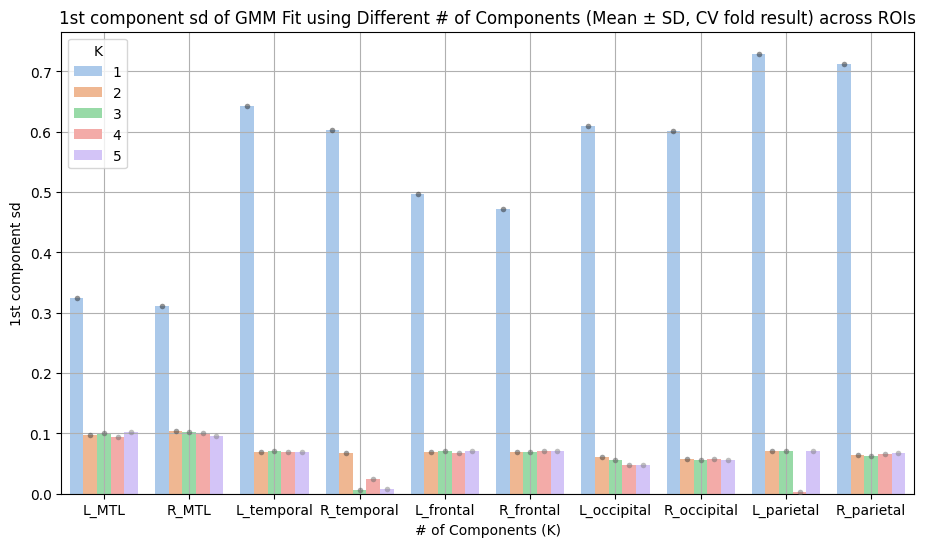

In [17]:
#1/2nd component mean with different components
plt.figure(figsize=(11, 6))
sns.barplot(data=bestk_df, y='sd1', hue='K', x='ROI',   errorbar='sd', errwidth=1, palette=sns.color_palette('pastel')) 
sns.stripplot(data=bestk_df, y='sd1', hue='K', x='ROI', dodge=True, color='gray', alpha=0.5, size=4, legend=False)

plt.xlabel('# of Components (K)')
plt.ylabel('1st component sd')
plt.title('1st component sd of GMM Fit using Different # of Components (Mean ± SD, CV fold result) across ROIs')
plt.legend(title='K')
plt.grid(True)
plt.show() 

### weight

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


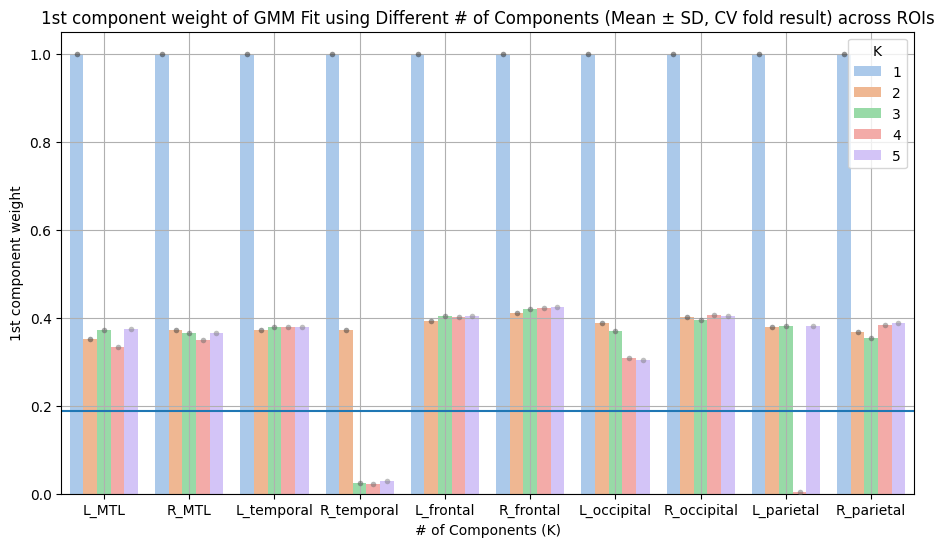

In [18]:
#1/2nd component mean with different components
plt.figure(figsize=(11, 6))
sns.barplot(data=bestk_df, y='weight1', hue='K', x='ROI',   errorbar='sd', errwidth=1, palette=sns.color_palette('pastel')) 
sns.stripplot(data=bestk_df, y='weight1', hue='K', x='ROI', dodge=True, color='gray', alpha=0.5, size=4, legend=False)

plt.xlabel('# of Components (K)')
plt.ylabel('1st component weight')
plt.axhline(y=88/(88+379))
plt.title('1st component weight of GMM Fit using Different # of Components (Mean ± SD, CV fold result) across ROIs')
plt.legend(title='K')
plt.grid(True)
plt.show() 

## plot mixture

In [5]:
def plot_mixture(gmm, roi_data, show_legend=True, ax=None):
    sns.set_palette('tab10') 
    if ax is None:
        ax = plt.gca() 
    # Whole mixture
    x = np.linspace(min(roi_data), max(roi_data), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob) 
    # indiviudal component
    weights = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = weights * pdf[:, np.newaxis]  
    # data hist
    ax.hist(roi_data, 30, density=True, histtype='stepfilled',color='gray', alpha=0.4)
    # whole pdf
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    # compoennt pdf
    ax.plot(x, pdf_individual, '--')
    if show_legend:
        ax.legend()


In [6]:
max_c = 3 #max num of component starting from 1
names = ['R_occipital','L_occipital','R_MTL','R_temporal'] # specify roi to plot
sns.set_palette('tab10')
for roi in names:
    roi_idx = lobes.index(roi)
    roi_data = dat[:, roi_idx]   
    roibestk = bestK[bestK.ROI == roi].K.values[0]
    models = [GaussianMixture(n_components=k).fit(roi_data.reshape(-1, 1)) for k in np.arange(max_c) + 1]

    _, axes = plt.subplots(int(np.ceil(max_c/3)), 3, figsize=np.array([3,int(np.ceil(max_c/3))])*3, dpi=100,sharex=True)
    idx = 0
    for gmm, ax in zip(models, axes.ravel()):
        plot_mixture(gmm, roi_data, show_legend=False, ax=ax)
        idx = idx+1
        ax.set_title(f'k={gmm.n_components}')
        plt.suptitle(f'1-3 component GMM fit on mean SUVR in {roi} (Best: K = {roibestk})')
        # to set label
        if idx == 2:
            ax.set_xlabel('mean SUVR')
        if idx == 1:
            ax.set_ylabel('Density')
    
    plt.tight_layout()

NameError: name 'bestK' is not defined

## standardization


https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html cov 

covariance_type{‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’, each component has its own covariance matrix (in 1d just one value)

In [7]:
#compk = dict(zip(list(bestK.ROI),list(bestK.K)))
compk = dict(zip(list(bestK.ROI),[3 for i in range(10)]))
compct = 2 
compk 

NameError: name 'bestK' is not defined

In [30]:
gmm1mean = []
gmm1std = []
gmm1weight = []
gmmk = []
gmmbic = []
dat = pd.read_csv(cpath+'wide_data.csv').loc[:,lobes].values #read in the data agian
gmm_data = dat.copy()
for roi in lobes:
    roi_idx = lobes.index(roi)
    
    gmm_model = GaussianMixture(n_components=compk[roi], init_params='random_from_data',random_state=42,covariance_type='full',n_init=100,max_iter=300)
    # Fit GMM to the column data/a specific roi
    gmm_model.fit(gmm_data[:, roi_idx].reshape(-1, 1)) 
    # Get the means of the two components
    means = gmm_model.means_.flatten()  
    weights = gmm_model.weights_.flatten()  
    # sort it by smaller mean = first component
    c1_idx = np.argmin(means)
   
    std = np.sqrt(gmm_model.covariances_[c1_idx])[0][0] 
    mean = means[c1_idx] 
    gmm1mean.append(mean)
    gmm1weight.append(weights[c1_idx])
    gmm1std.append(std)
    gmmk.append('full')
    gmmbic.append(gmm_model.bic((gmm_data[:, roi_idx].reshape(-1, 1))))
    #standardize
    gmm_data[:, roi_idx] = (gmm_data[:, roi_idx] - mean)/std


In [31]:
gmm_ctrl = gmm_data[cn_idx]
gmm_eoad = gmm_data[eoad_idx]
gmmdf = pd.DataFrame(gmm_data,columns=lobes)
gmmdf['dx'] = df.dx
gmmdf['subj'] = df.subj
gmmdf.to_csv(cpath+'gdata'+str(compct)+'.csv',index=False)

gmm_stat = pd.DataFrame( {
    'lobe': lobes,
    'K': gmmk,
    'mean1': gmm1mean,
    'sd1': gmm1std,
    'weights':gmm1weight,
    'bic':gmmbic
})
gmm_stat.to_csv(cpath+'gmmstats'+str(compct)+'.csv')

### cn and eoad mean/sd

In [32]:
 
# Check that the mean of the control population  
print('Mean of controls is ',np.mean(gmm_ctrl,axis=0))
# Check that the standard deviation of the control population  
print('Standard deviation of controls is ',np.std(gmm_ctrl,axis=0))
# Check that the mean of the whole dataset is positive
print('Mean of whole dataset is ',np.mean(gmm_data,axis=0))
# Check that the standard deviation of the whole dataset is greater than 1
print('Standard deviation of whole dataset is ',np.std(gmm_data,axis=0))


Mean of controls is  [-0.09513728 -0.23211191 -0.18287673 -0.10058555 -0.14582553 -0.1074515
 -0.02941238 -0.09763517  0.10713965  0.05886011]
Standard deviation of controls is  [0.82084274 0.71556028 0.7952354  0.8657736  0.71934056 0.79131924
 0.88763616 0.91043031 0.9151321  0.87053736]
Mean of whole dataset is  [ 3.3346235   2.47225762  9.38053736  9.49217868  5.63580325  5.42650627
  9.23351033  8.7987398  11.36910449 10.35560981]
Standard deviation of whole dataset is  [ 3.27632929  2.66452347  9.18799278  9.28679917  6.46474671  6.4695491
 10.83343204 10.71074494 11.17630736 10.42188597]


### KDE

In [33]:
def pdf_roi(df, description, xlab, eoad_idx = eoad_idx, cn_idx = cn_idx,  
            rois = lobes, col = sns.color_palette('tab20')):
 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    # Plot KDEs for cn and eoad
    for idx, lobe in enumerate(rois):
        sns.kdeplot(df.loc[eoad_idx, lobe], label='EOAD', linestyle='solid', color=col[idx], ax=axes[1])
        sns.kdeplot(df.loc[cn_idx, lobe], label='CN', linestyle='dashed', color=col[idx], ax=axes[1])
        axes[1].set_title('CN/EOAD separate')
        axes[1].set_xlabel(xlab)
        handles, labels = axes[1].get_legend_handles_labels() 
    # Plot KDEs for all data
    for idx, lobe in enumerate(rois):
        sns.kdeplot(df.loc[:, lobe], label=f'{lobe}', linestyle='solid', color=col[idx], ax=axes[0])
        axes[0].set_title('all data')
        axes[0].set_xlabel(xlab)    
    # Add legends
    axes[0].legend(loc='upper right', title='ROI')
    axes[1].legend(handles[0:2],labels[0:2],loc='upper right', title='dx')
    # Set common title
    plt.suptitle(f'KDE plots of {description} in each ROI')
    plt.tight_layout()
    plt.show()
    return fig, axes


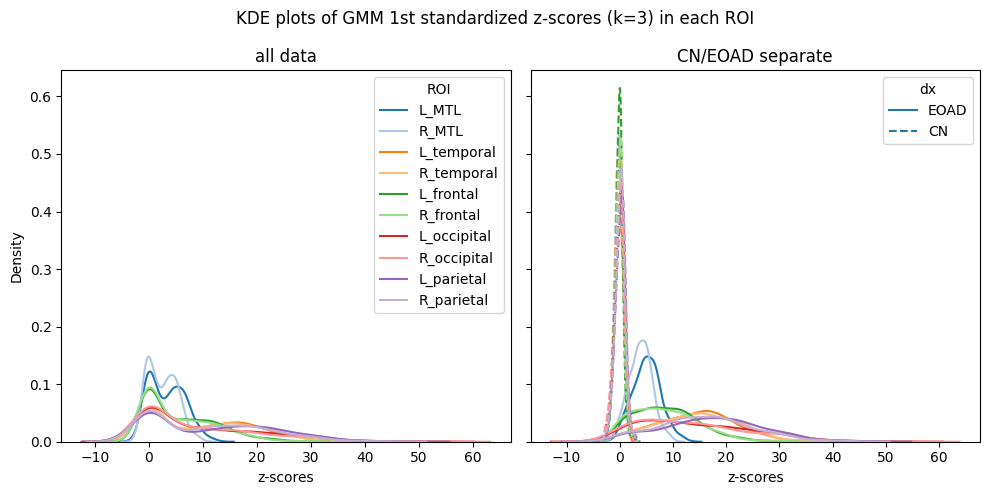

In [28]:
fig, axes = pdf_roi(gmmdf,f'GMM 1st standardized z-scores (k={compct})', 'z-scores')

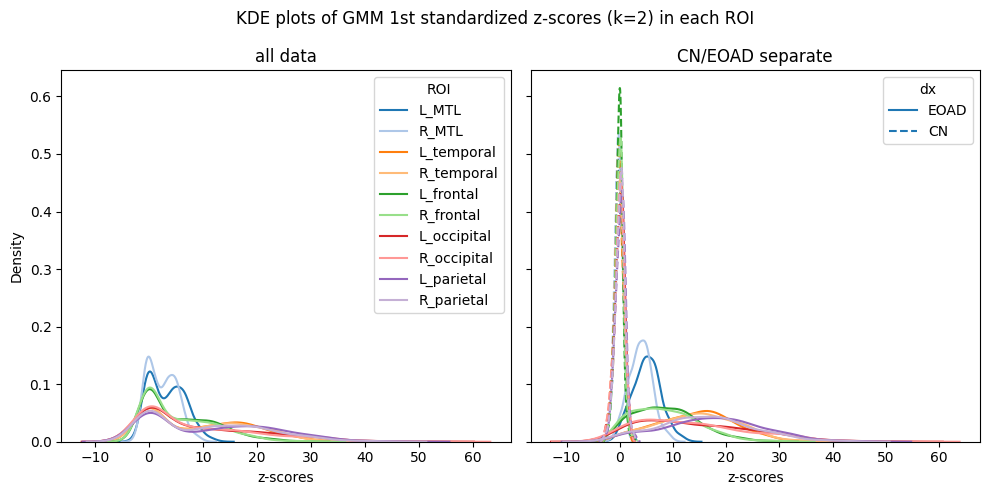

In [34]:
fig, axes = pdf_roi(gmmdf,f'GMM 1st standardized z-scores (k={compct})', 'z-scores')